# Classical classifiers

This notebook shows how well classical classifiers solve the sentence classification problem that is chosen for the pre-alpha prototype. This is mainly needed to have a baseline for quantum solution to compare against.

We first load our library files and the required packages.

In [1]:
import sys
import os
import json
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

sys.path.append("../../../my_lib/src/ClassicalNLP/Classifier/")

from NNClassifier import (loadData,evaluate, NNClassifier,
       prepareTrainTestXYWords, prepareTrainTestXYSentence,)

For data vectorizing separate services are used which are run as Docker containers. To simplify the presentation via Jupyter notebook, for demonstration we will just load the already vectorized data.

We have implemented sentence vectorization using pretrained _BERT_ (see [Git](https://github.com/google-research/bert), [arXiv](https://arxiv.org/abs/1810.04805)) base model (each sentence is represented as a 768-dimensional real-valued vector),
as well as word-level vectorization using [_fastText_](https://fasttext.cc/) model [pretrained on English Wikipedia](https://fasttext.cc/docs/en/pretrained-vectors.html) (each word in a sentence is represented as a 300-dimensional real-valued vector).

We will start with the BERT sentence-level vectorization.

In [2]:
data = loadData("../../../my_lib/src/ClassicalNLP/Datasets/dataset_vectorized_bert_uncased.json")
print(f"Training samples: {len(data['train_data'])}, test samples: {len(data['test_data'])}")
print(f"An example sentence: {data['train_data'][2]['sentence']}, type: {data['train_data'][2]['sentence_type']}, truth value: {data['train_data'][2]['truth_value']}")
print(f"Vectorized sentence dimension: {len(data['train_data'][0]['sentence_vectorized'][0])}")

Training samples: 89, test samples: 23
An example sentence: chicken eats fox, type: NOUN-TVERB-NOUN, truth value: False
Vectorized sentence dimension: 768


We reformat the data as numpy arrays for classifier training. 

In [3]:
trainX, trainY, testX, testY = prepareTrainTestXYSentence(data)
print(f"{trainX.shape}")
print(f"{trainY.shape}")
print(f"{testX.shape}")
print(f"{testY.shape}")

(89, 768)
(89, 2)
(23, 768)
(23, 2)


We test the accuracy of classifying the sentence with the label corresponding to the closest sentence in the training data.

In [4]:
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(trainX, trainY)
res = neigh.predict(testX)
bert_neigh_test_acc = np.sum(res == testY)/2/len(testY)
bert_neigh_train_acc = neigh.score(trainX, trainY)
print(f"Nearest neighbor test accuracy: {bert_neigh_test_acc}, train accuracy: {bert_neigh_train_acc}")

Nearest neighbor test accuracy: 0.6956521739130435, train accuracy: 1.0


Now we train a feedforward neural network classifier.

In [5]:
classifier = NNClassifier()
history = classifier.train(trainX, trainY)

Epoch 1/100
3/3 - 0s - loss: 0.7401 - accuracy: 0.4157
Epoch 2/100
3/3 - 0s - loss: 0.7191 - accuracy: 0.5056
Epoch 3/100
3/3 - 0s - loss: 0.6936 - accuracy: 0.4831
Epoch 4/100
3/3 - 0s - loss: 0.6743 - accuracy: 0.5506
Epoch 5/100
3/3 - 0s - loss: 0.6599 - accuracy: 0.5955
Epoch 6/100
3/3 - 0s - loss: 0.6435 - accuracy: 0.6180
Epoch 7/100
3/3 - 0s - loss: 0.6314 - accuracy: 0.6742
Epoch 8/100
3/3 - 0s - loss: 0.6195 - accuracy: 0.6517
Epoch 9/100
3/3 - 0s - loss: 0.6101 - accuracy: 0.6517
Epoch 10/100
3/3 - 0s - loss: 0.5989 - accuracy: 0.6966
Epoch 11/100
3/3 - 0s - loss: 0.5903 - accuracy: 0.6966
Epoch 12/100
3/3 - 0s - loss: 0.5840 - accuracy: 0.7191
Epoch 13/100
3/3 - 0s - loss: 0.5755 - accuracy: 0.7416
Epoch 14/100
3/3 - 0s - loss: 0.5704 - accuracy: 0.7303
Epoch 15/100
3/3 - 0s - loss: 0.5619 - accuracy: 0.7191
Epoch 16/100
3/3 - 0s - loss: 0.5568 - accuracy: 0.7191
Epoch 17/100
3/3 - 0s - loss: 0.5509 - accuracy: 0.7528
Epoch 18/100
3/3 - 0s - loss: 0.5480 - accuracy: 0.7416
E

In [6]:
bert_nn_train_acc = history.history["accuracy"][-1]
print(f"FNN train accuracy on BERT vectors: {bert_nn_train_acc}")

FNN train accuracy on BERT vectors: 0.8764045238494873


And measure the accuracy on the test set.

In [7]:
res = classifier.predict(testX)
bert_nn_test_acc = evaluate(res, testY)
print(f"FFNN test accuracy on BERT vectors: {bert_nn_test_acc}")

FFNN test accuracy on BERT vectors: 0.6521739130434783


Depending on random, the NN classifier might perform better or worse (or the same) than the 1-nearest neighbor algorithm.

Now we load fastText word embeddings and train a convolutional network on them.

In [8]:
data = loadData("../../../my_lib/src/ClassicalNLP/Datasets/dataset_vectorized_fasttext.json")

maxLen = 5
trainX, trainY, testX, testY = prepareTrainTestXYWords(data, maxLen)

classifier = NNClassifier(model="CNN", vectorSpaceSize=300)
history = classifier.train(trainX, trainY)

Epoch 1/30
3/3 - 0s - loss: 0.9306 - accuracy: 0.5056
Epoch 2/30
3/3 - 0s - loss: 0.6573 - accuracy: 0.5955
Epoch 3/30
3/3 - 0s - loss: 0.6196 - accuracy: 0.6517
Epoch 4/30
3/3 - 0s - loss: 0.5565 - accuracy: 0.7191
Epoch 5/30
3/3 - 0s - loss: 0.5238 - accuracy: 0.7528
Epoch 6/30
3/3 - 0s - loss: 0.4537 - accuracy: 0.7978
Epoch 7/30
3/3 - 0s - loss: 0.4636 - accuracy: 0.7753
Epoch 8/30
3/3 - 0s - loss: 0.4205 - accuracy: 0.7865
Epoch 9/30
3/3 - 0s - loss: 0.4005 - accuracy: 0.8202
Epoch 10/30
3/3 - 0s - loss: 0.3991 - accuracy: 0.8427
Epoch 11/30
3/3 - 0s - loss: 0.3729 - accuracy: 0.8539
Epoch 12/30
3/3 - 0s - loss: 0.3737 - accuracy: 0.8090
Epoch 13/30
3/3 - 0s - loss: 0.3541 - accuracy: 0.8202
Epoch 14/30
3/3 - 0s - loss: 0.3531 - accuracy: 0.8315
Epoch 15/30
3/3 - 0s - loss: 0.3000 - accuracy: 0.9213
Epoch 16/30
3/3 - 0s - loss: 0.2730 - accuracy: 0.9101
Epoch 17/30
3/3 - 0s - loss: 0.2688 - accuracy: 0.8989
Epoch 18/30
3/3 - 0s - loss: 0.3506 - accuracy: 0.8652
Epoch 19/30
3/3 - 0

In [9]:
fasttext_nn_train_acc = history.history['accuracy'][-1]
print(f"CNN train accuracy on fastText vectors: {fasttext_nn_train_acc}")

CNN train accuracy on fastText vectors: 0.9213483333587646


In [10]:
res = classifier.predict(testX)
fasttext_nn_test_acc = evaluate(res, testY)
print(f"CNN test accuracy on fastText vectors: {fasttext_nn_test_acc}")

CNN test accuracy on fastText vectors: 0.8260869565217391


Typically the convolutional network performs better than the previous algorithms.

Here is the whole set of results plotted

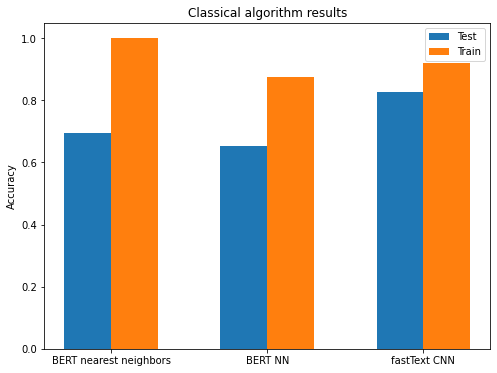

In [11]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)
test_accs = [bert_neigh_test_acc, bert_nn_test_acc, fasttext_nn_test_acc]
train_accs = [bert_neigh_train_acc, bert_nn_train_acc, fasttext_nn_train_acc]
labels = ["BERT nearest neighbors", "BERT NN", "fastText CNN"]
width = 0.3
plt.bar(np.arange(len(test_accs)) - (width/2), test_accs, width=width)
plt.bar(np.arange(len(train_accs)) + (width/2), train_accs, width=width)
plt.xticks(range(len(labels)), labels)
plt.ylabel("Accuracy")
plt.title("Classical algorithm results")
plt.legend(["Test", "Train"])
plt.show()

A promising future direction to explore seems to be implementing vectorizing using BERT that outputs word embeddings for each word in a sentence and training a convolutional network on top of them.